## Object Detection Pipeline on UCS using Darknet & YOLO

This notebook focuses on implementing object detection as a Kubeflow pipeline on Cisco UCS by using Darknet which is a open-source neural network framework, YOLO (You Only Look Once) which is a real-time object detection system.

## Clone Cisco Kubeflow starter pack repository

In [1]:
BRANCH_NAME="dev" #Provide git branch "master" or "dev"
! git clone -b $BRANCH_NAME https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

Cloning into 'cisco-kubeflow-starter-pack'...
remote: Enumerating objects: 6028, done.
remote: Total 6028 (delta 0), reused 0 (delta 0), pack-reused 6028
Receiving objects: 100% (6028/6028), 42.31 MiB | 49.51 MiB/s, done.
Resolving deltas: 100% (2381/2381), done.


## Install required packages

In [1]:
!python3 -m pip install --upgrade pip
!pip install kfp pillow --user

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pip in /home/jovyan/.local/lib/python3.6/site-packages (20.2.4)


## Restart kernel

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Import libraries

In [71]:
import os
import json
import time
import yaml
import calendar
import requests
import logging
import numpy as np
from PIL import Image, ImageDraw

#Kubeflow
import kfp
from kfp.aws import use_aws_secret
import kfp.compiler as compiler

#Kubernetes
from kubernetes import client

#Tensorflow
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

## Load pipeline components

Declare the paths of respective YAML configuration files of each of the pipeline components, in order to load each component into a variable for pipeline execution. 

In [72]:
path='cisco-kubeflow-starter-pack/apps/computer-vision/object-detection/onprem/pipeline/components/v2/'
component_root_dwn= path+'download/'
component_root_katib= path+'katib/'
component_root_train= path+'train/'
component_root_validate= path+'validate/'
component_root_convert=path+'conversion/'
component_root_kfserving=path+'kfserving/'

download_op = kfp.components.load_component_from_file(os.path.join(component_root_dwn, 'component.yaml'))
hptuning_op = kfp.components.load_component_from_file(os.path.join(component_root_katib, 'component.yaml'))
train_op = kfp.components.load_component_from_file(os.path.join(component_root_train, 'component.yaml'))
validate_op = kfp.components.load_component_from_file(os.path.join(component_root_validate, 'component.yaml'))
convert_op=kfp.components.load_component_from_file(os.path.join(component_root_convert, 'component.yaml'))
kfserving_op = kfp.components.load_component_from_file(os.path.join(component_root_kfserving, 'component.yaml'))

## Define volume claim & volume mount for storage during pipeline execution

Persistent volume claim & volume mount is created for the purpose of storing entities such as Dataset, model files, etc, and to share the stored resources between the various components of the pipeline during it's execution. 

In [73]:
nfs_pvc = client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs')
nfs_volume = client.V1Volume(name='nfs', persistent_volume_claim=nfs_pvc)
nfs_volume_mount = client.V1VolumeMount(mount_path='/mnt/', name='nfs')

## Define pipeline function

In [74]:
gpus=4 # Number of GPUs to run training

def object_detection_pipeline(
    s3_path="s3://object-det-test/001",    # AWS S3 bucket URL. Ex: s3://<bucket-name>/ 
    namespace='kubeflow',               # Namespace on which trained model is to be deployed for prediction
    inferenceservice_name="",           # Name of inference service and model name 
    timestamp="",                       # Current timestamp
    cfg_data="voc.data",                # Config file containing file name specifications of train, test and validate datasets
    cfg_file="yolov3-voc.cfg",          # Config file containing hyperparameters declarations Ex: yolov3.cfg / yolov4.cfg
    weights="yolov3-voc_50000.weights", # Weights which are already pre-trained upto 50000 iterations is used. Therefore,  
                                        # training happens from 50000 iterations upto a limit of max_batches (say 50200) specified 
                                        # in cfg_file. 
    trials=2,                           # Total number of trials under Katib experiment
    gpus_per_trial=2,                   # Maximum GPUS to be used for each trial
    classes_file="voc.names"            # File containing the names of object classes (such as person, bus, car,etc)
):
    # Download component
    dwn_task = download_op(s3_path=s3_path,
                           cfg_data=cfg_data,
                           timestamp=timestamp
                          ).apply(use_aws_secret(secret_name='aws-secret', aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))
    dwn_task.add_volume(nfs_volume)
    dwn_task.add_volume_mount(nfs_volume_mount) 
    
    # HP tuning (Katib) component
    hptuning_task = hptuning_op(cfg_data=cfg_data,             # Config file containing file name specifications of train, test and validate datasets
                                cfg_file=cfg_file,             # Config file containing hyperparameters declarations Ex: yolov3.cfg / yolov4.cfg
                                weights=weights,               # Pre-trained weights for VOC dataset
                                trials=trials,                 # total number of trials under Katib experiment
                                timestamp=timestamp,           # Current timestamp to create unique experiment 
                                                               # Ex: object-detection-1599547688-random-588d7877f5-zvlx5
                                gpus_per_trial=gpus_per_trial, # Maximum GPUS to be used for each trial 
                                )
    hptuning_task.add_volume(nfs_volume)
    hptuning_task.add_volume_mount(nfs_volume_mount)
    hptuning_task.after(dwn_task)
    
    # Train component
    train_task = train_op(cfg_data=cfg_data,          # Config file containing file name specifications of train, test and validate datasets
                          cfg_file=cfg_file,          # Config file containing hyperparameters declarations Ex: yolov3.cfg / yolov4.cfg
                          weights=weights,            # Pre-trained weights for VOC dataset
                          gpus=gpus,             
                          timestamp=timestamp
                         )
    train_task.add_volume(nfs_volume)
    train_task.add_volume_mount(nfs_volume_mount).set_gpu_limit(gpus)  #Maximum GPUs to be used for training
    train_task.after(hptuning_task)
    
    # Validation component
    validate_task = validate_op(s3_path=s3_path,
                                cfg_data=cfg_data,          # Config file containing file name specifications of train, test and validate datasets
                                cfg_file=cfg_file,          # Config file containing hyperparameters declarations Ex: yolov3.cfg / yolov4.cfg
                                weights=weights,            # Pre-trained weights for VOC dataset
                                timestamp=timestamp
                               ).apply(use_aws_secret(secret_name='aws-secret', aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))
    validate_task.add_volume(nfs_volume)
    validate_task.add_volume_mount(nfs_volume_mount)
    validate_task.after(train_task)

    # Model conversion component
    conversion_task=convert_op(push_to_s3="true",  # Flag to decide whether to upload the trained weights and converted
                                                    # model to S3 bucket for future inferencing on anyother environment or
                                                    # proceeding to serve on UCS (Input: true/false)
                               s3_path=s3_path,
                               classes_file=classes_file,
                               timestamp=timestamp
                               ).apply(use_aws_secret(secret_name='aws-secret', aws_access_key_id_name='AWS_ACCESS_KEY_ID', aws_secret_access_key_name='AWS_SECRET_ACCESS_KEY'))
    conversion_task.add_volume(nfs_volume)
    conversion_task.add_volume_mount(nfs_volume_mount)
    conversion_task.after(validate_task)
    
    # KFserving component
    kfserving = kfserving_op(inferenceservice_name=inferenceservice_name,
                            classes_file=classes_file,
                            namespace=namespace,
                            timestamp=timestamp).set_image_pull_policy('Always')
    kfserving.add_volume(nfs_volume)
    kfserving.add_volume_mount(nfs_volume_mount)
    kfserving.after(conversion_task)

## Compile pipeline function

Compile the pipeline function to create a tar ball for the pipeline.

In [75]:
# Compile pipeline
try:
    compiler.Compiler().compile(object_detection_pipeline, 'object-detection.tar.gz')
except RuntimeError as err:
    logging.debug(err)
    logging.info("Argo workflow failed validation check but it can still be used to run experiments.")

## Create pipeline experiment

In [76]:
kp_client = kfp.Client()
EXPERIMENT_NAME = 'Object Detection'
experiment = kp_client.create_experiment(name=EXPERIMENT_NAME)

## Initialize pipeline parameters & run pipeline

In [77]:
#Pipeline parameters
timestamp = str(calendar.timegm(time.gmtime()))
trials=4
gpus_per_trial=2
inferenceservice_name="object-detection-%s"%timestamp

# Execute pipeline
run = kp_client.run_pipeline(experiment.id, 'object-detection', 'object-detection.tar.gz', 
                          params={"timestamp": timestamp,
                                  "inferenceservice_name": inferenceservice_name,
                                  "trials": trials,
                                  "gpus_per_trial": gpus_per_trial})

## Run a prediction
### Check if inference service is Ready
Before running a prediction, make sure that pipeline run is completed in the dashboard.

In [78]:
!kubectl get inferenceservice $inferenceservice_name -n kubeflow

NAME                          URL                                                                                             READY   DEFAULT TRAFFIC   CANARY TRAFFIC   AGE
object-detection-1606130986   http://object-detection-1606130986.kubeflow.example.com/v1/models/object-detection-1606130986   True    100                                119s


#### Note:
Wait for inference service READY="True"

In [79]:
CLUSTER='ucs' #where your cluster is running :'gcp' or 'ucs'

### Get cluster & inference details

Get Ingress IP, Port and Inferenceservice host name to be used for prediction

In [80]:
%%bash -s "$CLUSTER" "$inferenceservice_name" --out NODE_INFERENCE
if [ $1 = "ucs" ]
then
    echo "$(kubectl get node -o=jsonpath='{.items[0].status.addresses[0].address}')"
else
    echo "$(kubectl get node -o=jsonpath='{.items[0].status.addresses[1].address}')"
fi

INGRESS_GATEWAY="istio-ingressgateway"
echo "$(kubectl -n istio-system get service $INGRESS_GATEWAY -o jsonpath='{.spec.ports[1].nodePort}')"

echo "$(kubectl get inferenceservice $2 -n kubeflow -o jsonpath='{.status.url}' | cut -d "/" -f 3)"

### Image Pre-processing, Prediction & Post-processing

* Define functions for preprocessing Image & predicting object detection boxes.
* Predicted output is post-processed to display object detection boxes of the image.

In [81]:
#Client data preprocess function
def letter_box_image(image: Image.Image, output_height: int, output_width: int, fill_value)-> np.ndarray:
    height_ratio = float(output_height)/image.size[1]
    width_ratio = float(output_width)/image.size[0]
    fit_ratio = min(width_ratio, height_ratio)
    fit_height = int(image.size[1] * fit_ratio)
    fit_width = int(image.size[0] * fit_ratio)
    fit_image = np.asarray(image.resize((fit_width, fit_height), resample=Image.BILINEAR))

    if isinstance(fill_value, int):
        fill_value = np.full(fit_image.shape[2], fill_value, fit_image.dtype)

    to_return = np.tile(fill_value, (output_height, output_width, 1))
    pad_top = int(0.5 * (output_height - fit_height))
    pad_left = int(0.5 * (output_width - fit_width))
    to_return[pad_top:pad_top+fit_height, pad_left:pad_left+fit_width] = fit_image
    return to_return

# Function to predict object detected image data
def predict(img_data):
    headers = {"Host": NODE_INFERENCE.split('\n')[2]}
    data={"instances":img_data.tolist()}
    url = "http://%s:%s/v1/models/%s:predict"%(NODE_INFERENCE.split("\n")[0],NODE_INFERENCE.split("\n")[1], inferenceservice_name)
    response=requests.post(url, data=json.dumps(data), headers=headers)
    boxes=response.json()['predictions'][0]
    classes=response.json()['predictions'][1]
    scores=response.json()['predictions'][2]
    return boxes, classes, scores

#Post-process predicted output
def letter_box_pos_to_original_pos(letter_pos, current_size, ori_image_size)-> np.ndarray:
    letter_pos = np.asarray(letter_pos, dtype=np.float)
    current_size = np.asarray(current_size, dtype=np.float)
    ori_image_size = np.asarray(ori_image_size, dtype=np.float)
    final_ratio = min(current_size[0]/ori_image_size[0], current_size[1]/ori_image_size[1])
    pad = 0.5 * (current_size - final_ratio * ori_image_size)
    pad = pad.astype(np.int32)
    to_return_pos = (letter_pos - pad) / final_ratio
    return to_return_pos

def convert_to_original_size(box, size, original_size, is_letter_box_image):
    if is_letter_box_image:
        box = box.reshape(2, 2)
        box[0, :] = letter_box_pos_to_original_pos(box[0, :], size, original_size)
        box[1, :] = letter_box_pos_to_original_pos(box[1, :], size, original_size)
    else:
        ratio = original_size / size
        box = box.reshape(2, 2) * ratio
    return list(box.reshape(-1))

def draw_boxes(boxes, classes, scores, img, detection_size, is_letter_box_image):
    draw = ImageDraw.Draw(img)

    color = 255,0,0#np.random.randint(0, 256, 3))
    for box, score, cls in zip(boxes, scores, classes):
        box = convert_to_original_size(box, np.array(detection_size),
                                       np.array(img.size),
                                       is_letter_box_image)
        draw.rectangle(box, outline=color)
        draw.text(box[:2], '{} {:.2f}%'.format(cls, score * 100), fill=color)
    return img

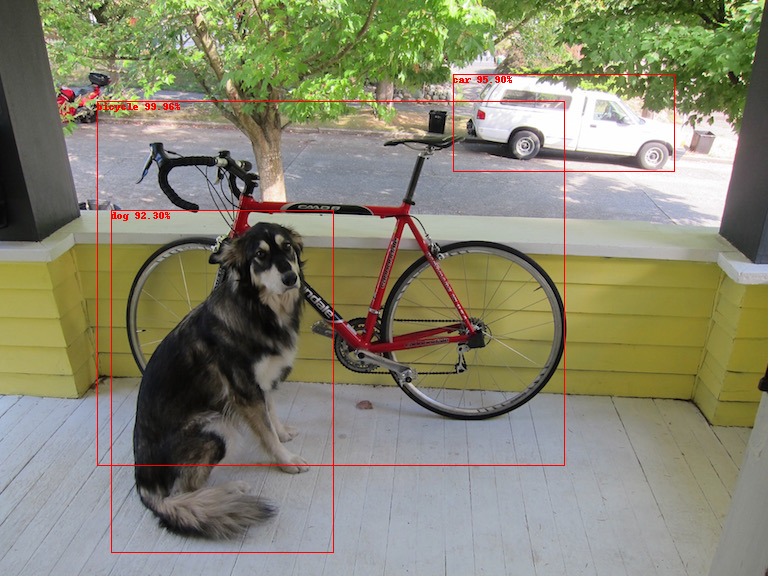

In [82]:
#Call client data preprocess function
img = Image.open('dog.jpg')
img_resized = letter_box_image(img, 416, 416, 128)
img_resized = img_resized.astype(np.float32)

#Call predict function
boxes, classes, scores = predict(img_resized)
draw_boxes(np.asarray(boxes), classes, np.asarray(scores), img, (416, 416), True)

## Clean up

Clean up deployed inference service

In [83]:
!kubectl delete inferenceservice $inferenceservice_name -n kubeflow

inferenceservice.serving.kubeflow.org "object-detection-1606130986" deleted
